# Import modules

In [67]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
# from tqdm import tqdm
# import concurrent.futures

import sys
sys.path.append('../')

from src.config import *
from src.helper_visualization import *
from src.helper_pred import *

# Prepare Data

## Load Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104449 entries, 0 to 104448
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   Request ID                  104449 non-null  int64 
 1   Title                       104449 non-null  object
 2   Product Name                104449 non-null  object
 3   Length                      104449 non-null  int64 
 4   Language                    104449 non-null  object
 5   Title_Processed             104449 non-null  object
 6   Title_Translated            104449 non-null  object
 7   Title_Cleaned               104449 non-null  object
 8   Old Product Name            104449 non-null  object
 9   Title_Product_Name_Removed  104439 non-null  object
dtypes: int64(2), object(8)
memory usage: 8.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11606 entries, 0 to 11605
Data columns (total 10 columns):
 #   Column                      Non-Null

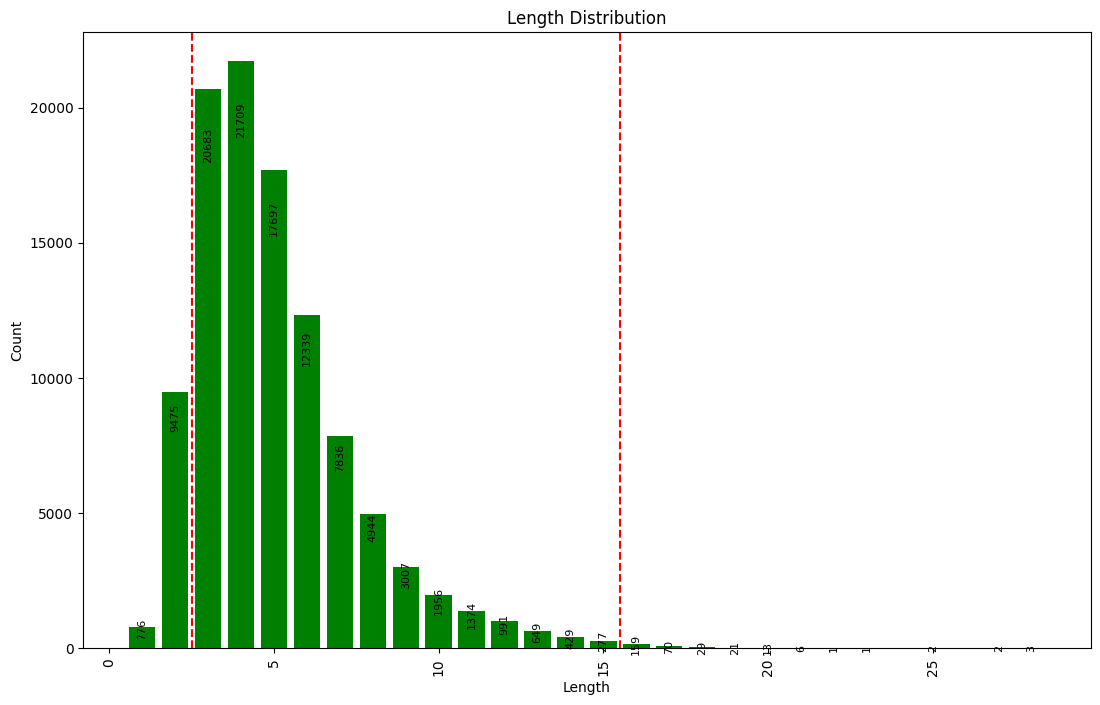

In [68]:
# excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_cleaned.xlsx'
excel_file_train = f'{DATA_FOLDER_PATH_PROCESSED}/data_train.xlsx'
df_train = pd.read_excel(excel_file_train)
excel_file_test = f'{DATA_FOLDER_PATH_PROCESSED}/data_test.xlsx'
df_test = pd.read_excel(excel_file_test)

print(df_train.info())
print(df_test.info())
hist_by_labels(df_train, 'Length', log=False, left=2.5, right=15.5)
# plot a square in red color on the histogram

## Remove short Titles

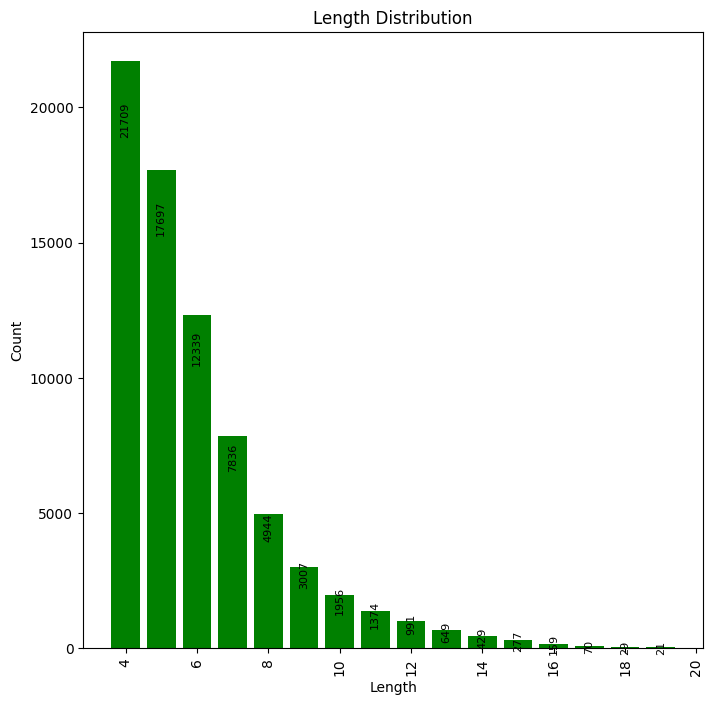

In [69]:
# filter out the titles with length less than 3 and more than 20
# when the title is too short, it is either not useful or it is too obvious to be classified
mask = (df_train['Length'] > 3) & (df_train['Length'] < 20)
df_train = df_train[mask]
hist_by_labels(df_train, 'Length', horizontal=True)

## Combine the long tail into Others

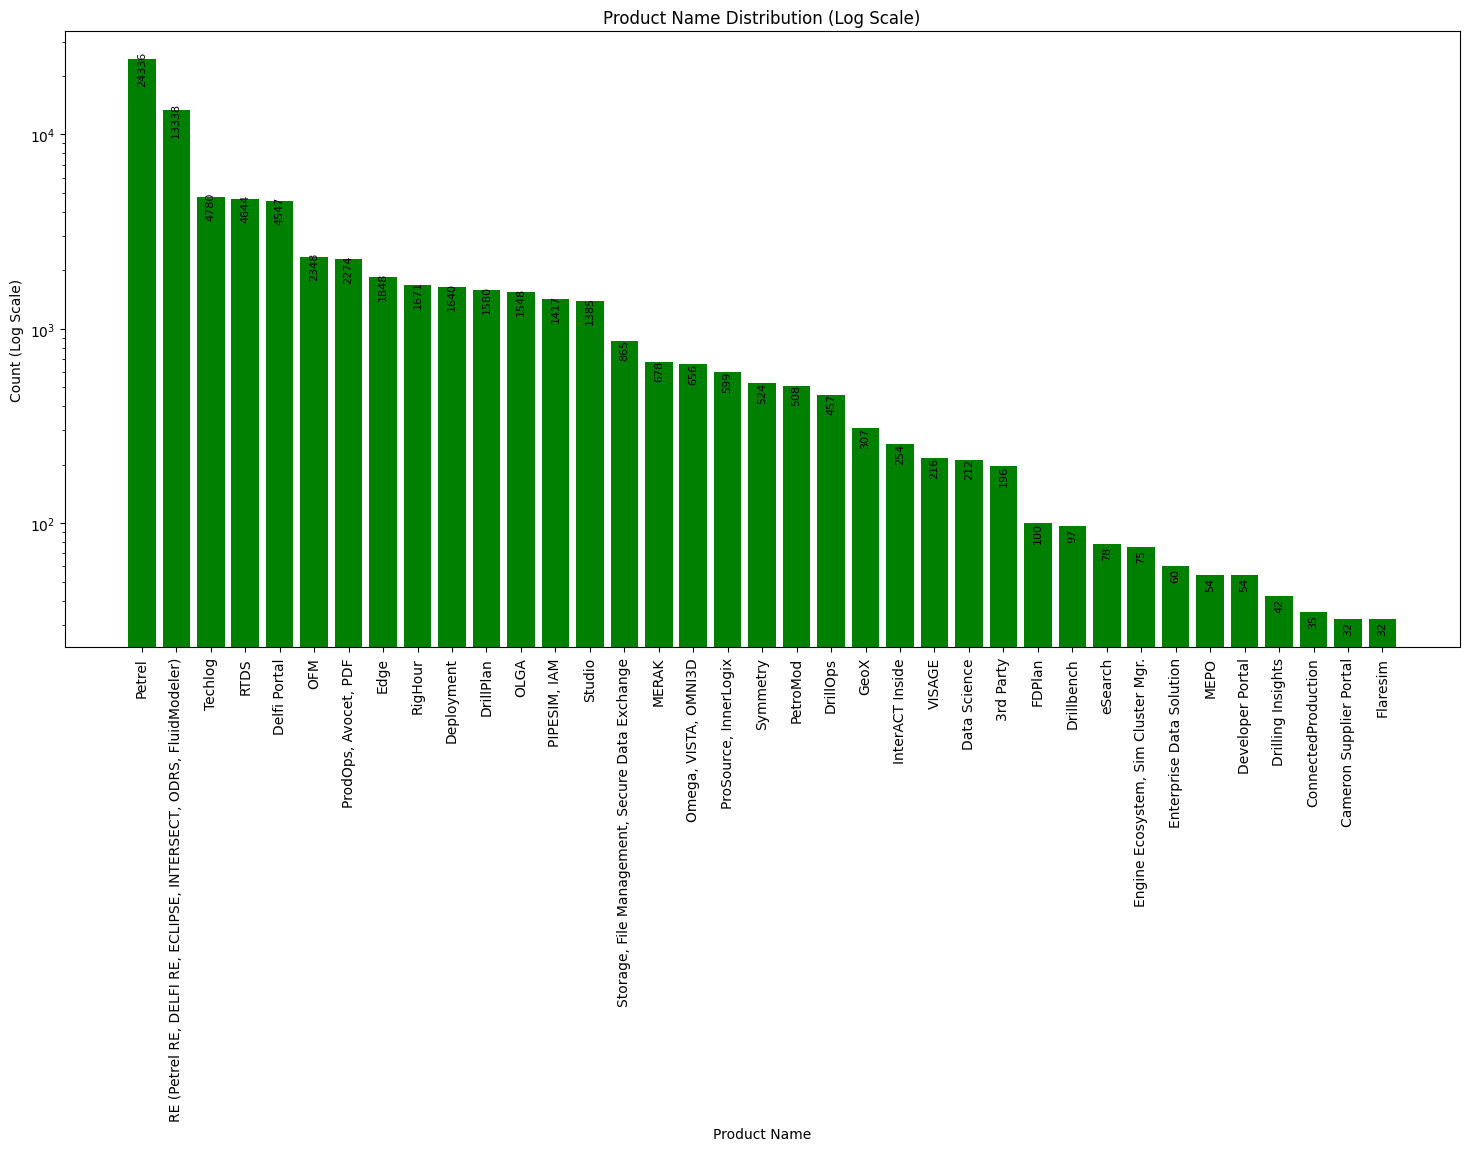

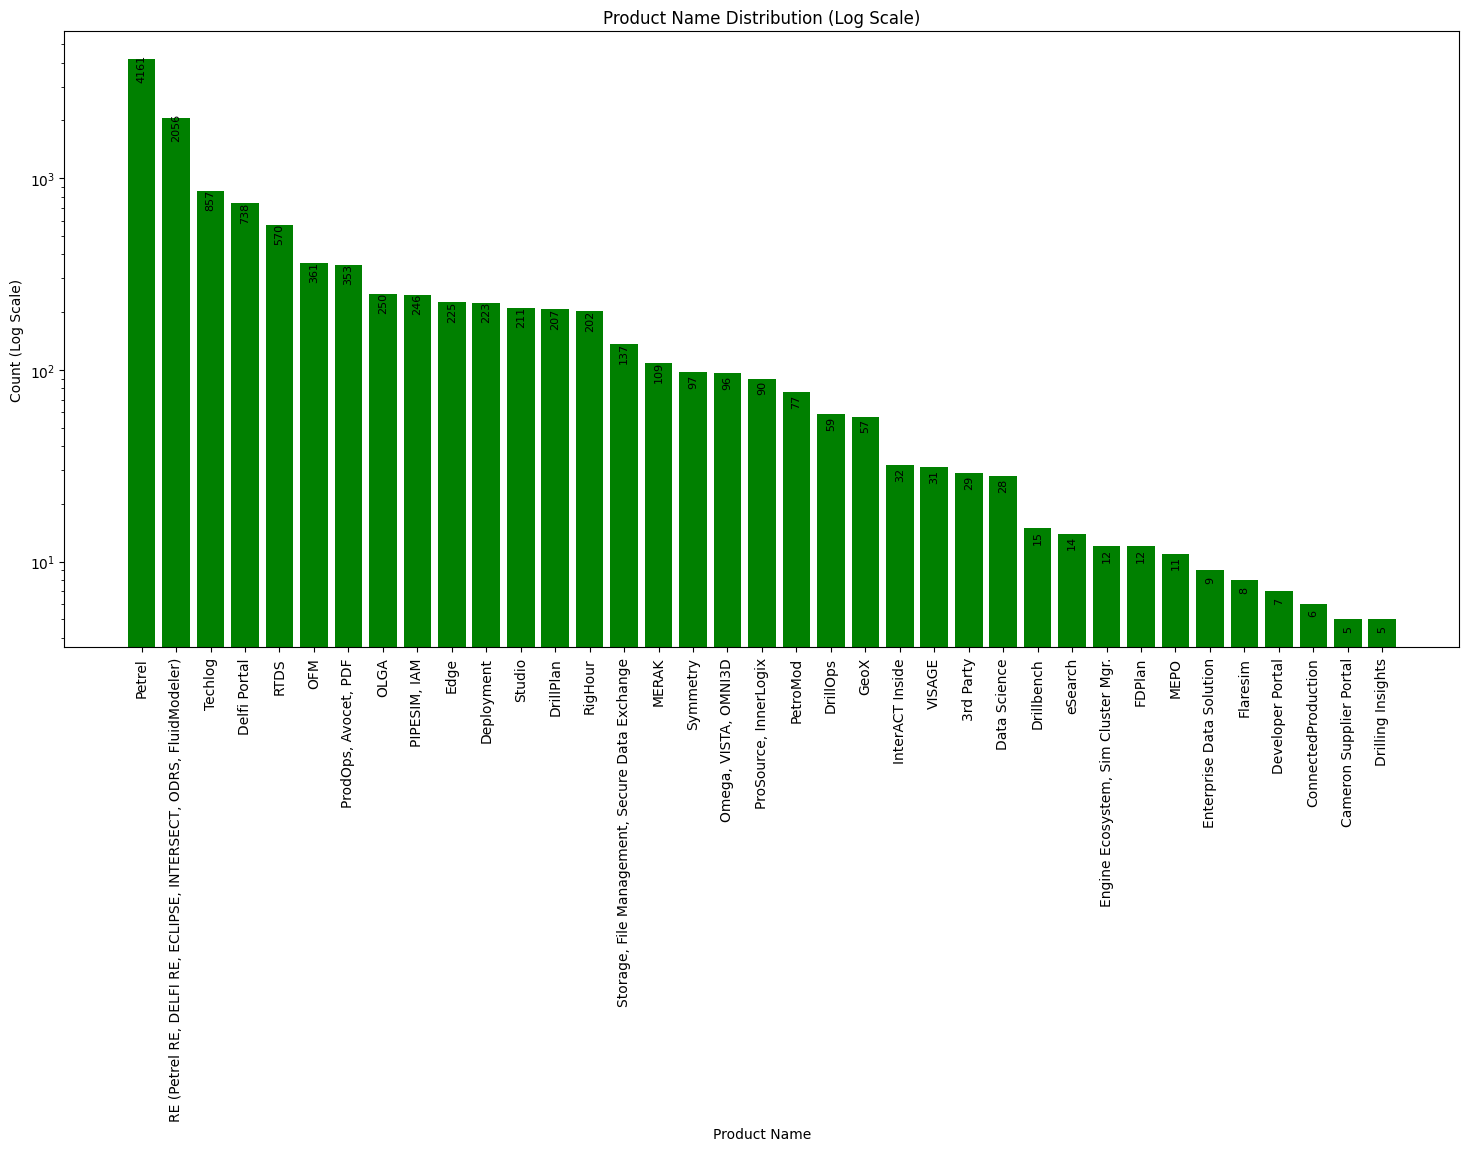

In [70]:
hist_by_labels(df_train, 'Product Name', top=None, log=True, horizontal=True)
hist_by_labels(df_test, 'Product Name', top=None, log=True, horizontal=True)

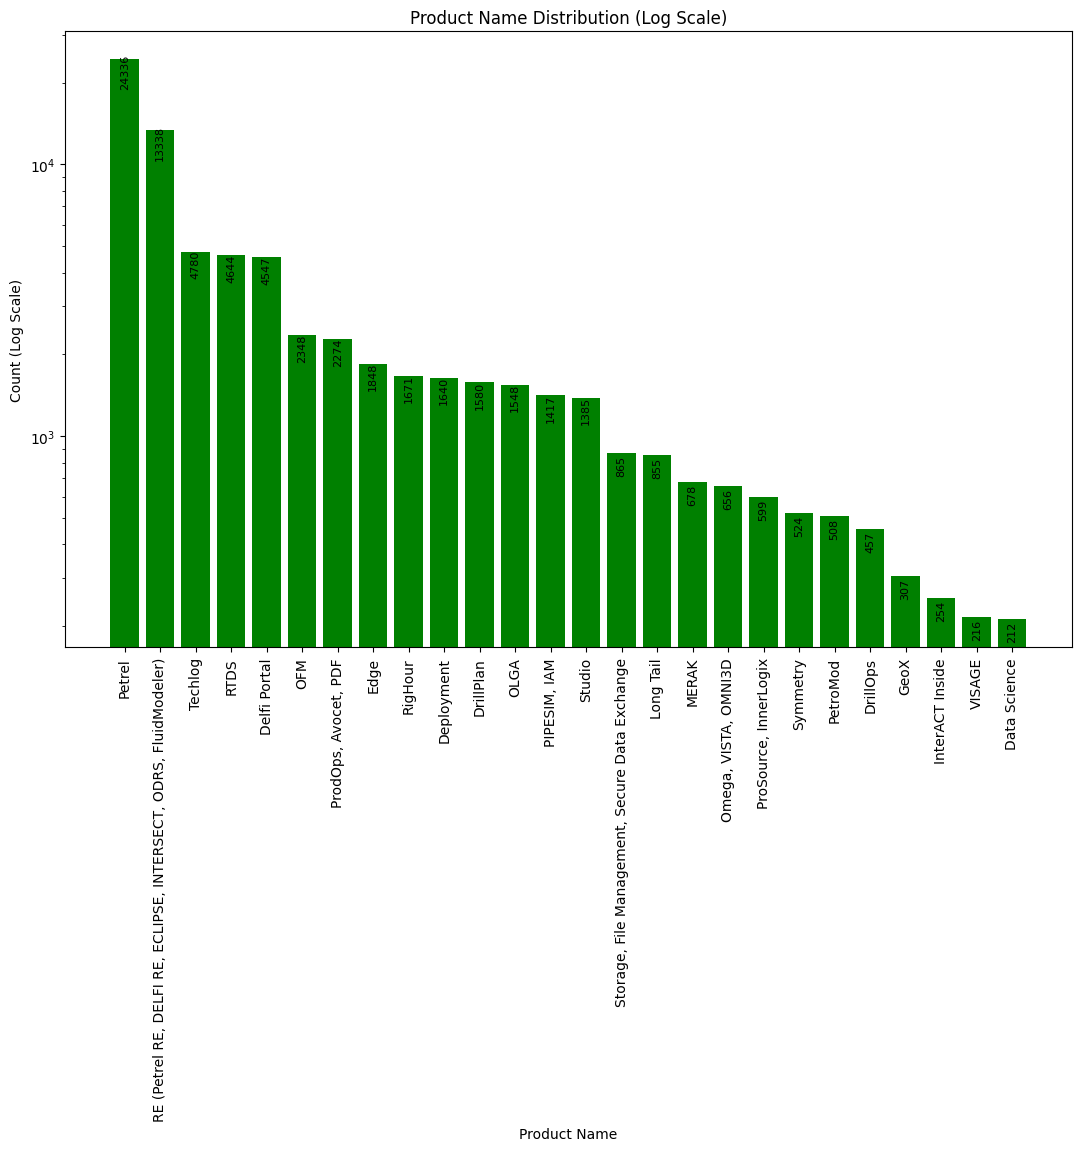

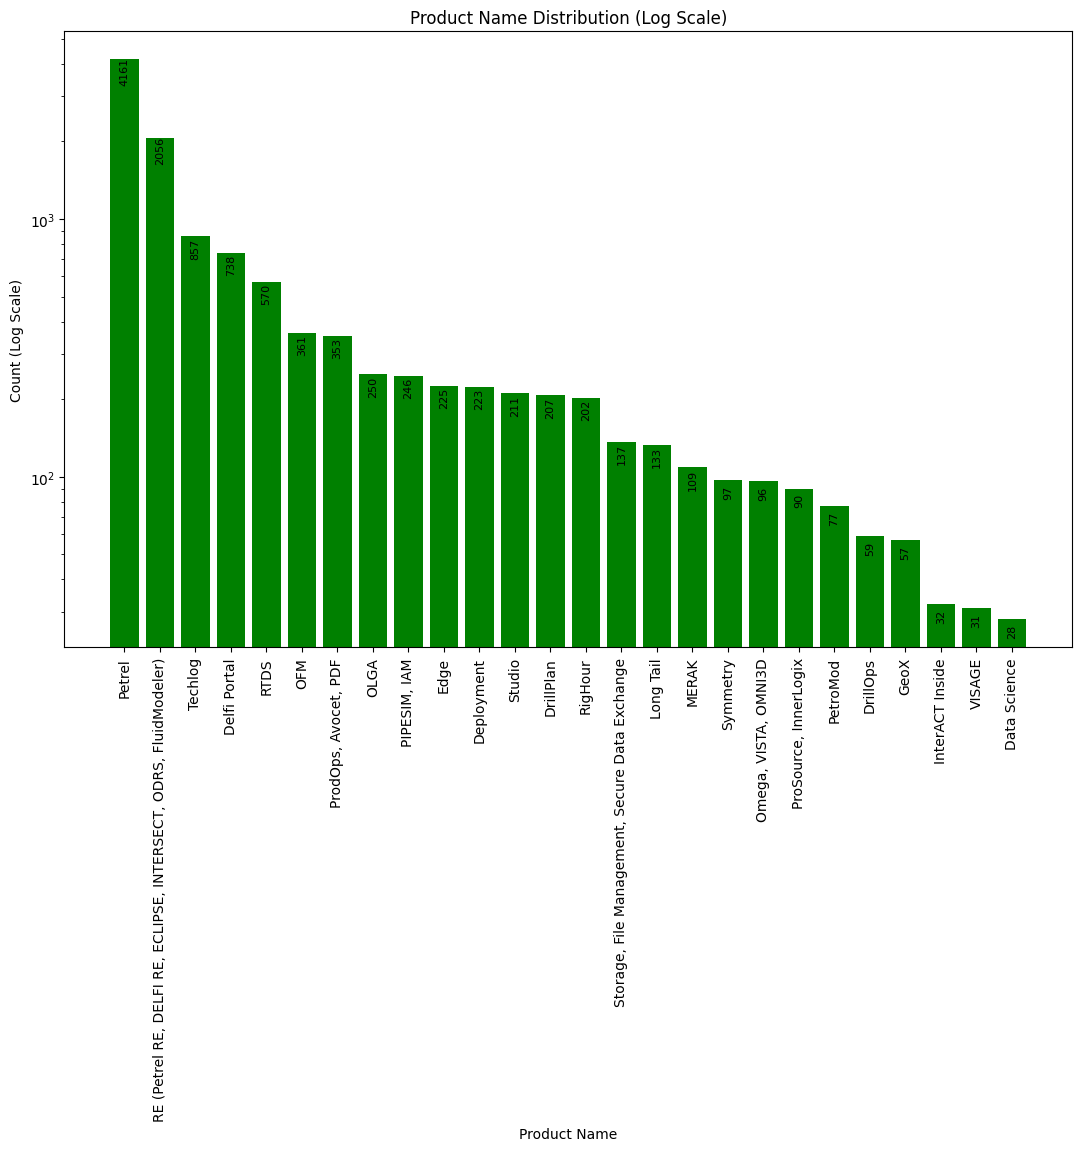

In [71]:
# Keep the top 50 products and combine the rest into 'Others'
cutoff = 200

product_counts = df_train['Product Name'].value_counts()
product_top = product_counts.index[product_counts >= cutoff]
product_others = product_counts.index[product_counts < cutoff]

mask_others = df_train['Product Name'].isin(product_others)
df_train.loc[mask_others,'Product Name']='Long Tail'

mask_others = df_test['Product Name'].isin(product_others)
df_test.loc[mask_others,'Product Name']='Long Tail'

hist_by_labels(df_train, 'Product Name', log=True)
hist_by_labels(df_test, 'Product Name', log=True)

## Balance Train and Test Data

<class 'pandas.core.frame.DataFrame'>
Index: 31220 entries, 0 to 104129
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Request ID                  31220 non-null  int64 
 1   Title                       31220 non-null  object
 2   Product Name                31220 non-null  object
 3   Length                      31220 non-null  int64 
 4   Language                    31220 non-null  object
 5   Title_Processed             31220 non-null  object
 6   Title_Translated            31220 non-null  object
 7   Title_Cleaned               31220 non-null  object
 8   Old Product Name            31220 non-null  object
 9   Title_Product_Name_Removed  31220 non-null  object
dtypes: int64(2), object(8)
memory usage: 2.6+ MB
None


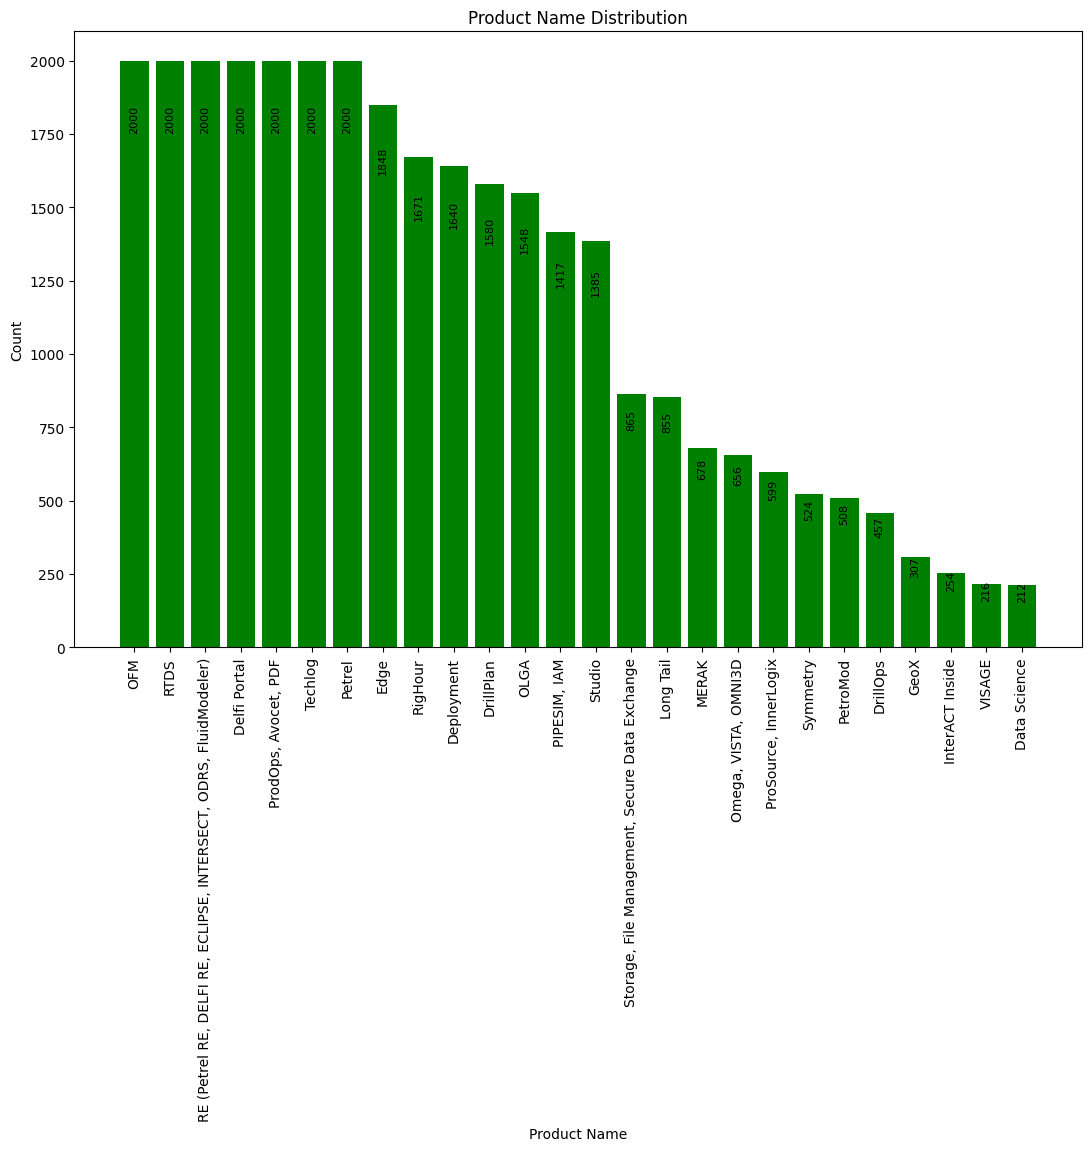

In [84]:
# for the products with more than 5000 records, randomly select 4000 records for each product and put in a new dataframe df_cleaned_balanced, then keep the rest of the records in df_cleaned_test
max_size = 2000

df_train_balanced = pd.DataFrame()

for product in df_train['Product Name'].unique():
    df_product = df_train[df_train['Product Name'] == product]
    if df_product.shape[0] > max_size:
        df_product_balanced = df_product.sample(max_size).copy()
    else:
        df_product_balanced = df_product.copy()
    df_train_balanced = pd.concat([df_train_balanced, df_product_balanced])

print(df_train_balanced.info())

hist_by_labels(df_train_balanced, 'Product Name', log=False)

<class 'pandas.core.frame.DataFrame'>
Index: 4610 entries, 0 to 11531
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Request ID                  4610 non-null   int64 
 1   Title                       4610 non-null   object
 2   Product Name                4610 non-null   object
 3   Length                      4610 non-null   int64 
 4   Language                    4610 non-null   object
 5   Title_Processed             4610 non-null   object
 6   Title_Translated            4610 non-null   object
 7   Title_Cleaned               4610 non-null   object
 8   Old Product Name            4610 non-null   object
 9   Title_Product_Name_Removed  4610 non-null   object
dtypes: int64(2), object(8)
memory usage: 396.2+ KB
None


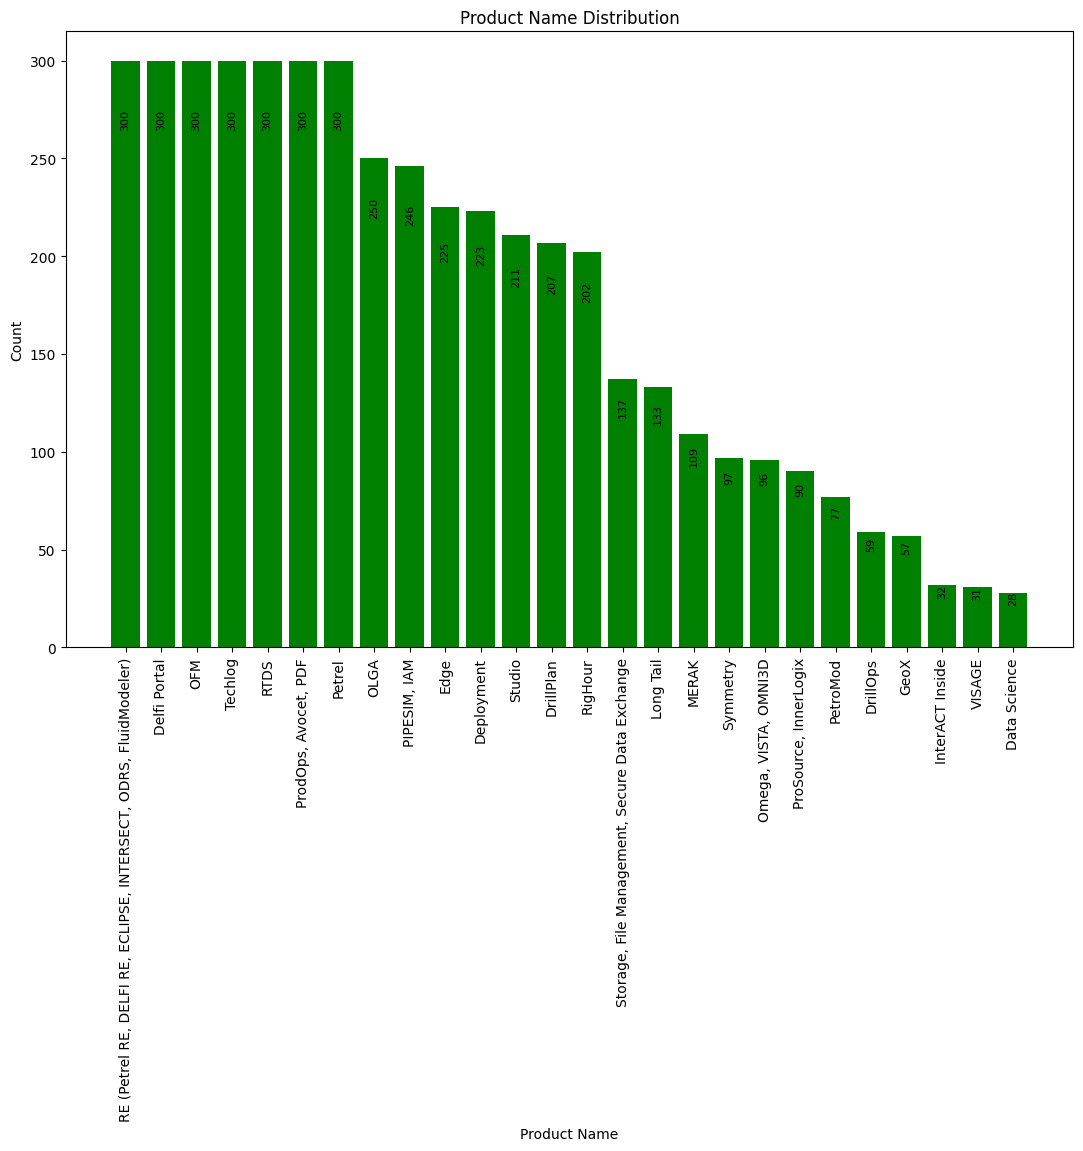

In [81]:
max_size = 300

df_test_balanced = pd.DataFrame()

for product in df_test['Product Name'].unique():
    df_product = df_test[df_test['Product Name'] == product]
    if df_product.shape[0] > max_size:
        df_product_balanced = df_product.sample(max_size).copy()
    else:
        df_product_balanced = df_product.copy()
    df_test_balanced = pd.concat([df_test_balanced, df_product_balanced])

print(df_test_balanced.info())


hist_by_labels(df_test_balanced, 'Product Name', log=False)

In [ ]:
df_train_balanced.head(-10)

In [85]:
# Prepare data for training and testing for 
# a. cross validation
# b. logistic regression, 
# c. SGC Classifier

#import packages related to data
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

column_name_train = 'Title_Cleaned'
column_name_test = 'Title_Cleaned'

X = df_train[column_name]

vectorizer_countvec = CountVectorizer(max_features=20000, analyzer='word', ngram_range=(1, 2))
vectorizer_countvec.fit(X)

vectorizer_tfidf = TfidfVectorizer(max_features=20000, analyzer='word', ngram_range=(1, 2))
vectorizer_tfidf.fit(X)

X_train = df_train_balanced[column_name_train]
y_train = df_train_balanced['Product Name']

X_test = df_test_balanced[column_name_test]
y_test = df_test_balanced['Product Name']

X_train_countvec = vectorizer_countvec.transform(X_train)
X_test_countvec = vectorizer_countvec.transform(X_test)

X_train_tfidf = vectorizer_tfidf.transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

# vectorizer = vectorizer_countvec
# X_train_encoded = X_train_countvec
# X_test_encoded = X_test_countvec

# vectorizer = vectorizer_tfidf
# X_train_encoded = X_train_tfidf
# X_test_encoded = X_test_tfidf

# Model Baseline - Cross Validation

In [ ]:
# Model Tuning
from sklearn.model_selection import cross_validate

# Models
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
# import xgboost as xgb

import optuna
import optuna.visualization as vis
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import pickle

In [86]:
models = {
    'SGDClassifier': SGDClassifier(max_iter=5000),
    'SVC linear': SVC(kernel='linear'),
    'LogisticRegression': LogisticRegression(max_iter=5000),
    # 'RandomForestClassifier': RandomForestClassifier(),
    # 'GradientBoostingClassifier': GradientBoostingClassifier(),
    # 'MultinomialNB': MultinomialNB(),
    # 'SVC rbf': SVC(kernel='rbf'),
}

print('Baseline Score(s) of each model are ....')

for model in models:
    cv_result = cross_val_score(
        models[model], 
        # X_train_countvec,
        X_train_tfidf,
        # X_train_glove,
        y_train, #the target
        cv=5, 
        scoring='accuracy', # lease revise to the appropriate score
        n_jobs=-1
    )
    print(f'Average score: \033[94m{"{:.4f}".format(np.mean(cv_result))}\033[0m by \033[94m{model}\033[0m.')

Baseline Score(s) of each model are ....
Average score: 0.8121 by SGDClassifier.
Average score: 0.8104 by SVC linear.
Average score: 0.7982 by LogisticRegression.


In [ ]:
Baseline Score(s) of each model are ....
Average score: 0.8096 by SGDClassifier.
Average score: 0.8105 by SVC linear.
Average score: 0.7953 by LogisticRegression.

# Hpyerparameter Tuning

## SGC Classifier

In [87]:
# Clean up the study if it exists
study_name = 'sgd_classifier'
storage_name = 'sqlite:///optuna_study.db'

In [88]:
try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass 

In [89]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e-3, log=True),
        'eta0': trial.suggest_float('eta0', 1e-3, 1e-1, log=True),
        'loss': trial.suggest_categorical('loss', ['log_loss', 'modified_huber']),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'adaptive']), #
        'max_iter': 10000,
        'random_state': 42
        }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    sgd_classifier = SGDClassifier(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(sgd_classifier, X_train_tfidf, y_train, cv=5, scoring='accuracy')
    
    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)

study.optimize(
    objective,
    n_trials=100, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_sore = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Score:", best_sore)

[I 2023-10-24 09:38:38,682] A new study created in RDB with name: sgd_classifier


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-10-24 09:38:40,887] Trial 7 finished with value: 0.8221652786675209 and parameters: {'alpha': 0.0001315741424307385, 'eta0': 0.007400204063563176, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'optimal'}. Best is trial 7 with value: 0.8221652786675209.
[I 2023-10-24 09:38:41,712] Trial 9 finished with value: 0.7033311979500321 and parameters: {'alpha': 0.00036953545657991064, 'eta0': 0.030681252069466213, 'loss': 'log_loss', 'penalty': 'l2', 'learning_rate': 'optimal'}. Best is trial 7 with value: 0.8221652786675209.
[I 2023-10-24 09:38:41,870] Trial 1 finished with value: 0.71736066623959 and parameters: {'alpha': 0.0006154526780933341, 'eta0': 0.05466315824071826, 'loss': 'modified_huber', 'penalty': 'l1', 'learning_rate': 'constant'}. Best is trial 7 with value: 0.8221652786675209.
[I 2023-10-24 09:38:42,434] Trial 5 finished with value: 0.5488148622677771 and parameters: {'alpha': 0.0007940903112731726, 'eta0': 0.0533092990996531, 'loss': 'log_loss', 'penalty'

In [ ]:
vis.plot_optimization_history(study)

In [ ]:
vis.plot_slice(study)

Accuracy: 0.794143
                                                                  precision    recall  f1-score   support

                                                    Data Science      0.731     0.679     0.704        28
                                                    Delfi Portal      0.648     0.713     0.679       300
                                                      Deployment      0.704     0.713     0.708       223
                                                        DrillOps      0.803     0.831     0.817        59
                                                       DrillPlan      0.764     0.874     0.815       207
                                                            Edge      0.982     0.973     0.978       225
                                                            GeoX      0.942     0.860     0.899        57
                                                 InterACT Inside      0.760     0.594     0.667        32
                          

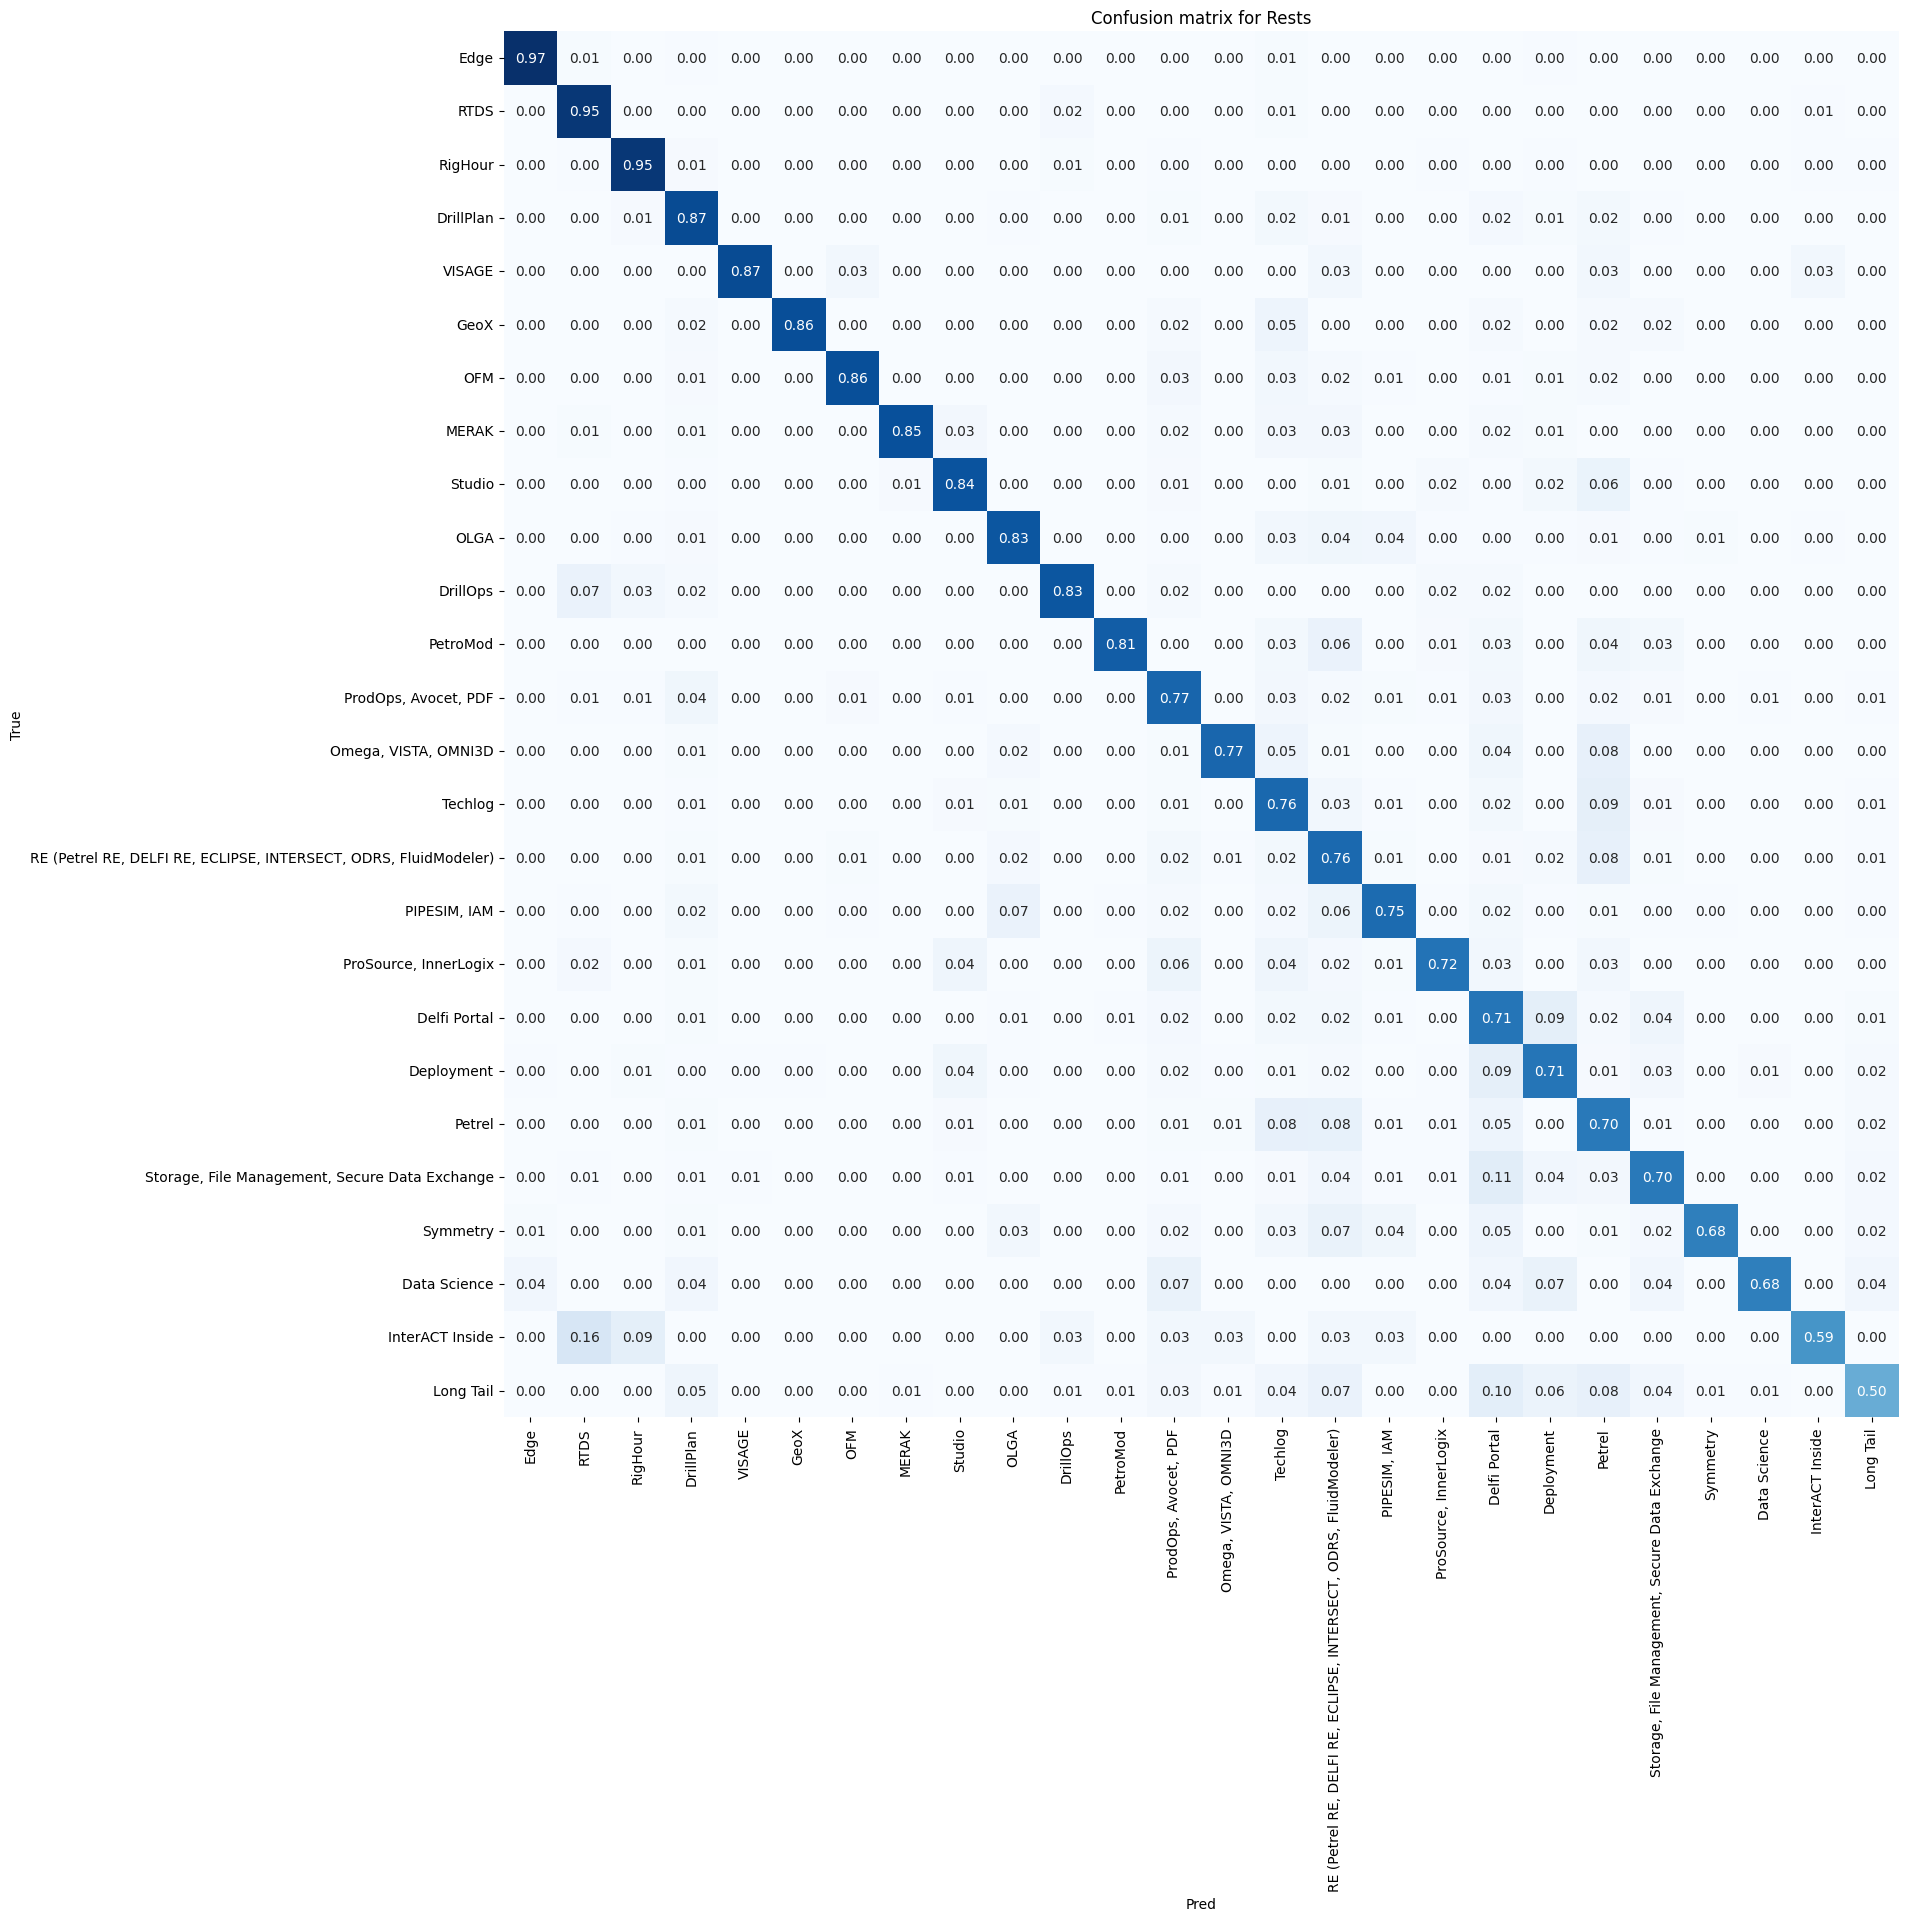

Accuracy of top 1 prediction is 0.794.
Accuracy of top 3 prediction is 0.905.
Accuracy of top 5 prediction is 0.936.


In [90]:
# Create and train the best Logistic Regression model
best_model_sgc = SGDClassifier(**best_params)
best_model_sgc.fit(X_train_tfidf, y_train)

# Predict categories for the test data
y_pred_sgc = best_model_sgc.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred_sgc)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

# Evaluate the classifier's performance
print(classification_report(y_test, y_pred_sgc, digits=3))
plot_confusion_matrix(y_test, y_pred_sgc, title='Confusion matrix for Rests')
df_pred_top5_sgc = top5_accuracy_report(best_model_sgc, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [ ]:
# export the model
pickle.dump(best_model_sgc, open(f'{MODEL_FOLDER_PATH}/model_sgc_classifier.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_sgc_classifier.pkl', 'wb'))

## Logistic Classification

In [ ]:
# Clean up the study if it exists
study_name = 'logReg'
storage_name = 'sqlite:///optuna_study.db'
try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass 

In [ ]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga', 'sag']),
        'C': trial.suggest_float('C', 1e-2, 1e+4, log=True),
        'penalty': 'l2',
        'multi_class': 'ovr',
        'max_iter': 10000,
        'random_state': 42
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    logReg = LogisticRegression(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(logReg, X_train_tfidf, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)

study.optimize(
    objective,
    n_trials=50, 
    n_jobs=-1, 
    show_progress_bar=True,
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

In [ ]:
vis.plot_optimization_history(study)

In [ ]:
vis.plot_slice(study)

In [ ]:
# Create and train the best Logistic Regression model
best_model_logReg= LogisticRegression(**best_params)
best_model_logReg.fit(X_train_tfidf, y_train)

# Step 4: Model Evaluation
y_pred_logReg = best_model_logReg.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_logReg)
print(f'Accuracy: \033[94m{accuracy:.4f}\033[0m')

report = classification_report(y_test, y_pred_logReg, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_logReg, title='Confusion matrix for Rests')
df_pred_top5_logReg = top5_accuracy_report(best_model_logReg, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [ ]:
# Create and train the best Logistic Regression model
model_logReg= LogisticRegression(max_iter=5000)
model_logReg.fit(X_train_tfidf, y_train)

# Step 4: Model Evaluation
y_pred_logReg = model_logReg.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_logReg)
print(f'Accuracy: \033[94m{accuracy:.4f}\033[0m')

report = classification_report(y_test, y_pred_logReg, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_logReg, title='Confusion matrix for Rests')
df_pred_top5_logReg = top5_accuracy_report(model_logReg, vectorizer_countvec, X_test, y_test, pre_processed=True)

In [ ]:
# export the model
import pickle
pickle.dump(best_model_logReg, open(f'{MODEL_FOLDER_PATH}/model_logistic_regression.pkl', 'wb'))

# export the vectorizer
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_logistic_regression.pkl', 'wb'))

## MultinomialNB

In [ ]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space of MultinomialNB model
    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e+2, log=True),
        'fit_prior': trial.suggest_categorical('fit_prior', [True, False])
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    model_multinomialNB = MultinomialNB(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(model_multinomialNB, X_train_countvec, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=250, 
    n_jobs=-1, 
    show_progress_bar=True,
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value

# Create and train the best Logistic Regression model
best_model_multinomialNB = MultinomialNB(**best_params)
best_model_multinomialNB.fit(X_train_countvec, y_train)
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

In [ ]:
# weights = df_rests['ProductName'].value_counts().apply(np.sqrt).to_dict()
model_multinomialNB = best_model_multinomialNB

# Step 4: Model Evaluation
y_pred_multinomialNB = model_multinomialNB.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_multinomialNB)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

report = classification_report(y_test, y_pred_multinomialNB, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_multinomialNB, title='Confusion matrix for Rests')
df_pred_top5_multinomialNB = top5_accuracy_report(model_multinomialNB, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [ ]:
# export the model and the vectorizer
pickle.dump(best_model_multinomialNB, open(f'{MODEL_FOLDER_PATH}/model_multinomialNB.pkl', 'wb'))
pickle.dump(vectorizer_countvec, open(f'{MODEL_FOLDER_PATH}/vectorizer_multinomialNB.pkl', 'wb'))

## SVC Linear

In [ ]:
study_name = 'SVC_linear'
storage_name = 'sqlite:///optuna_study.db'


In [ ]:
# Clean up the study if it exists
study_name = 'SVC_linear'
storage_name = 'sqlite:///optuna_study.db'
try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass 

In [ ]:
# user Optuna to tune the hyperparameters for SVC Linear
study_name = 'SVC_linear'
storage_name = 'sqlite:///optuna_study.db'

# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'C': trial.suggest_float('C', 1e-6, 1e+2, log=True),
        'max_iter': 50000,
        'random_state': 42,
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    model_svc_linear = SVC(kernel='linear', probability=True, **pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(model_svc_linear, X_train_tfidf, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)
study.optimize(
    objective,
    n_trials=10, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)

# Create and train the best Logistic Regression model
best_model_svc_linear = SVC(kernel='linear', **best_params)
best_model_svc_linear.fit(X_train_tfidf, y_train)

In [ ]:
vis.plot_optimization_history(study)

In [ ]:
vis.plot_slice(study)

In [ ]:
best_model_svc_linear = SVC(kernel='linear', probability=True, **best_params)
# best_model_svc_linear = SVC(kernel='linear', probability=True)
best_model_svc_linear.fit(X_train_tfidf, y_train)

# Step 4: Model Evaluation
y_pred_svc_linear = best_model_svc_linear.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_svc_linear)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

report = classification_report(y_test, y_pred_svc_linear, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_svc_linear, title='Confusion matrix for Rests')
df_pred_top5_svc_linear = top5_accuracy_report(best_model_svc_linear, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [ ]:
pickle.dump(best_model_svc_linear, open(f'{MODEL_FOLDER_PATH}/model_svc_linear.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_svc_linear.pkl', 'wb'))

## RandomForestClassifier

In [ ]:
# user Optuna to tune the hyperparameters for RandomForestClassifier

# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 4000, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        # 'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        # 'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    model_random_forest = RandomForestClassifier(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(model_random_forest, X_train_tfidf, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=10, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value
print("Best Hyperparameters:", best_params)

best_model_random_forest = RandomForestClassifier(**best_params)
best_model_random_forest.fit(X_train_tfidf, y_train)

# Step 4: Model Evaluation
y_pred_random_forest = best_model_random_forest.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_random_forest)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

report = classification_report(y_test, y_pred_random_forest, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_random_forest, title='Confusion matrix for Rests')
df_pred_top5_random_forest = top5_accuracy_report(best_model_random_forest, vectorizer_tfidf, X_test, y_test, pre_processed=True)

pickle.dump(best_model_random_forest, open(f'{MODEL_FOLDER_PATH}/model_random_forest.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_random_forest.pkl', 'wb'))

## Voting model

In [ ]:
# now we have three models, logistic regression, multinomialNB and svc_linear, we can use voting classifier to combine them together
from sklearn.ensemble import VotingClassifier

# Create a dictionary of the models
estimators = [
    ('logReg', best_model_logReg),
    ('sgc_classifier', best_model_sgc),
    ('svc_linear', best_model_svc_linear)
]

# Create a voting classifier
voting = VotingClassifier(estimators, voting='soft', n_jobs=-1)

# Fit the voting classifier to the training data
voting.fit(X_train_tfidf, y_train)

# Step 4: Model Evaluation
y_pred_voting = voting.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_voting)
print(f'Accuracy: \033[94m{accuracy:.4f}\033[0m')

report = classification_report(y_test, y_pred_voting, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_voting, title='Confusion matrix for Rests')

df_pred_top5_voting = top5_accuracy_report(voting, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [ ]:
pickle.dump(voting, open(f'{MODEL_FOLDER_PATH}/model_voting.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_voting.pkl', 'wb'))

# Word2Vec

In [ ]:
from gensim.models import Word2Vec
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
import optuna

# Load the pre-trained Word2Vec model
import gensim.downloader as api
word2vec_model = api.load('word2vec-google-news-300')

# train the word2vec_model using additional X_train data
# word2vec_model.build_vocab(X_train, update=True)
word2vec_model.train(X_train, total_examples=word2vec_model.corpus_count, epochs=word2vec_model.epochs)

# Define a function to encode the text using Word2Vec
def encode_text(text):
    words = text.split()
    vectors = []
    for word in words:
        if word in word2vec_model:
            vector = word2vec_model[word]
            vectors.append(vector)
    if len(vectors) == 0:
        return np.zeros(dim) # Return a vector of zeros if no words are found
    else:
        return np.mean(vectors, axis=0) # Return the mean of the word vectors

# Vectorize the training and testing data using Word2Vec
X_train_word2vec = [encode_text(text) for text in X_train]
X_test_word2vec = [encode_text(text) for text in X_test]


# Clean up the study if it exists
study_name = 'sgd_classifier_word2vec'
storage_name = 'sqlite:///optuna_study.db'
try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass

# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e-3, log=True),
        'eta0': trial.suggest_float('eta0', 1e-3, 1e-1, log=True),
        'loss': trial.suggest_categorical('loss', ['log_loss', 'modified_huber']),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'adaptive']), #
        'max_iter': 10000,
        'random_state': 42
        }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    sgd_classifier = SGDClassifier(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(sgd_classifier, X_train_word2vec, y_train, cv=5, scoring='accuracy')
    
    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)

study.optimize(
    objective,
    n_trials=10, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_sore = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Score:", best_sore)


In [ ]:

# Vectorize the training and testing data using Word2Vec
X_train_word2vec = [encode_text(text) for text in X_train]
X_test_word2vec = [encode_text(text) for text in X_test]


# Clean up the study if it exists
study_name = 'sgd_classifier_word2vec'
storage_name = 'sqlite:///optuna_study.db'
try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass

# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e-3, log=True),
        'eta0': trial.suggest_float('eta0', 1e-3, 1e-1, log=True),
        'loss': trial.suggest_categorical('loss', ['log_loss', 'modified_huber']),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'adaptive']), #
        'max_iter': 10000,
        'random_state': 42
        }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    sgd_classifier = SGDClassifier(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(sgd_classifier, X_train_word2vec, y_train, cv=5, scoring='accuracy')
    
    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)

study.optimize(
    objective,
    n_trials=10, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_sore = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Score:", best_sore)


In [ ]:
import gensim
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Load the pre-trained Word2Vec model
model = gensim.models.KeyedVectors.load_word2vec_format(f'{MODEL_FOLDER_PATH}/word2vec/GoogleNews-vectors-negative300.bin', binary=True, limit=200000)


In [ ]:
# Load the pre-trained GloVe embeddings
embeddings_index = {}
dim = 300

with open(f'{MODEL_FOLDER_PATH}/glove/glove.6B.{dim}d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Define a function to encode the text using GloVe
def encode_text(text):
    words = text.split()
    vectors = []
    for word in words:
        if word in embeddings_index:
            vector = embeddings_index[word]
            vectors.append(vector)
    if len(vectors) == 0:
        return np.zeros(dim) # Return a vector of zeros if no words are found
    else:
        return np.mean(vectors, axis=0) # Return the mean of the word vectors

# Vectorize the training and testing data using GloVe
X_train_glove = [encode_text(text) for text in X_train]
X_test_glove = [encode_text(text) for text in X_test]